# Workshop on Instance scene retrieval and localization


Course: NICF- Spatial Reasoning from Sensor Data (SF), https://www.iss.nus.edu.sg/executive-education/course/detail/spatial-reasoning-from-sensor-data/artificial-intelligence

Contact: Tian Jing

Email: tianjing@nus.edu.sg


## Objective

- Perform instance scene retrieval and localization

## Installation guideline

- Open `Anaconda Prompt`

- Append the channel `conda-forge` into your conda configuration.

`conda config --append channels conda-forge`

- Create a new virtual environment `srsdv` or install additional packages in your own environment

**[Windows, CPU version]**

`conda create -n srsdv python=3.6 numpy=1.15.1 opencv=3.4.2 matplotlib=2.2.3 tensorflow=1.10.0 scipy=1.1.0 scikit-learn=0.19.1 spyder=3.3.2 yaml=0.1.7 keras=2.2.4 pillow=5.4.1 notebook=5.7.4`

**[Windows, GPU version, CUDA 9.0]**

`conda create -n srsdv python=3.6 numpy=1.15.1 opencv=3.4.2 matplotlib=2.2.3 tensorflow-gpu=1.12.0 scipy=1.1.0 scikit-learn=0.19.1 spyder=3.3.2 yaml=0.1.7 keras-gpu=2.2.4 pillow=5.4.1 notebook=5.7.4`

- Activate the environment `srsdv`

`conda activate srsdv`

- Browse to the folder that contains the workshop files, then run `Jupyter Notebook`

`jupyter notebook`

## Reference

- Dataset: Scene recognition, https://www.cc.gatech.edu/~hays/compvision/proj4/. The place dataset is downloaded at https://www.cc.gatech.edu/~hays/compvision/proj4/data.zip
    
- This workshop code is modified from the original Caffe version in the following reference to be Keras version. 

- Refrence: 'Benchmark for Image Retrieval (BKIR)', https://github.com/willard-yuan/cnn-cbir-benchmark

## Submission guideline

Once you finish the workshop, rename your .ipynb file to your name, and submit your .ipynb file into LumiNUS.


In [1]:
import cv2
import os
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
from keras.applications import vgg16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from keras.layers import Flatten, Dense, Input
# apply GPU in training if GPU is available in your computer
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # model will be trained on GPU


Using TensorFlow backend.


## Prepare training images set and test images set

In [2]:
# Prepare the training folder and image file list
train_image_folder_name = 'data\\scene\\train'
train_image_file_list = []
train_image_class_list = []
# r=root, d=directories, f = files
for r, d, f in os.walk(train_image_folder_name):
    for direct in d:
        train_image_class_list.append(os.path.join(r, direct))
    for file in f:
        if '.jpg' in file:
            train_image_file_list.append(os.path.join(r, file))
    
print("Training: %d classes, %d images" % (len(train_image_class_list), len(train_image_file_list)))

# Prepare the test folder and image file list
test_image_folder_name = 'data\\scene\\test'
test_image_file_list = []
test_image_class_list = []
# r=root, d=directories, f = files
for r, d, f in os.walk(test_image_folder_name):
    for direct in d:
        test_image_class_list.append(os.path.join(r, direct))
    for file in f:
        if '.jpg' in file:
            test_image_file_list.append(os.path.join(r, file))
    
print("Test: %d classes, %d images" % (len(test_image_class_list), len(test_image_file_list)))


Training: 15 classes, 1500 images
Test: 15 classes, 2985 images


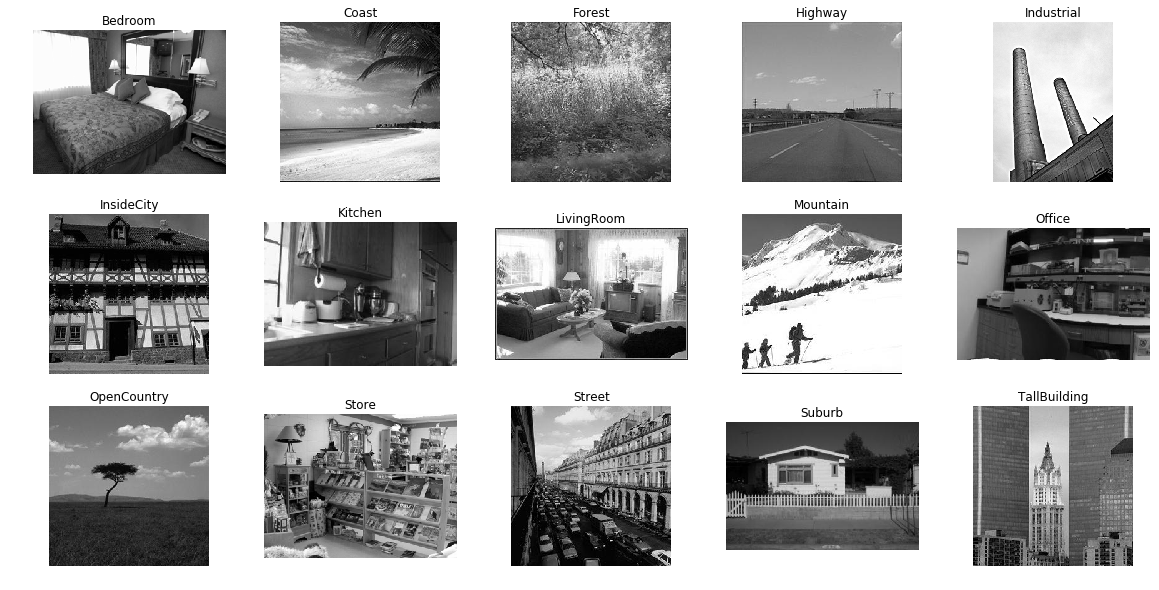

Training: 15 classes, 1515 images


In [3]:
# Illustrate sample training images
plt.figure(figsize=(20,10))
i = 0
for direct in train_image_class_list:
    for r, d, f in os.walk(direct):
        for file in f:
            if '.jpg' in file:
                train_image_file_list.append(os.path.join(r, file))
                i = i+1
                plt.subplot(3, 5, i)
                plt.imshow(cv2.imread(os.path.join(r, file)))
                plt.axis("off")
                plt.title(direct.split("\\")[3])
                break
plt.show()    
print("Training: %d classes, %d images" % (len(train_image_class_list), len(train_image_file_list)))


In [3]:
# Compare the input query file name and the result file name lists to calculate the precision performance
# For example
# input_file_name: data\scene\train\Mountain\image_0076.jpg
# result_file_name_list: a list of top_return files in query results
def cal_precision(input_file_name, result_file_name_list):
    num = 0
    input_class = input_file_name.split("\\")[3]
    for result_file_name in result_file_name_list:
        result_class = result_file_name.split("\\")[3]
        if (input_class == result_class):
            num = num+1
    return (num/len(result_file_name_list))

def cal_accuracy(input_file_name, result_file_name_list):
    result = 0
    input_class = input_file_name.split("\\")[3]
    for result_file_name in result_file_name_list:
        result_class = result_file_name.split("\\")[3]
        if (input_class == result_class):
            result = 1
            break
    return (result)

def cal_vec_dist(vec1, vec2):
    '''
    Description: calculate the Euclidean Distance of two vectors
    '''
    return np.linalg.norm(vec1 - vec2)


## VLAD: Step 0, Define functions

- Reference: Hervé Jegou, Florent Perronnin, Matthijs Douze, Jorge Sanchez, Patrick Perez, "Aggregating local image descriptors into compact codes," IEEE Trans. on Pattern Analysis and Machine Intelligence, Vol. 34, No. 9, 2012, pp.1704-1716. https://hal.inria.fr/inria-00633013/document/



In [4]:
# Configuration
vlad_CODEBOOKDIM = 100 # number of clusters
sift_DESDIM = 128 # dimension of SIFT

# Various functions used in VLAD
def sift_extractor(file_path):
    '''
    Description: extract SIFT feature from given image
    Input: file_path - image
    Output: des - a list of descriptors of all the keypoint from the image
    '''
    img = cv2.imread(file_path)
    gray= cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sift = cv2.xfeatures2d.SIFT_create(nfeatures=500) # number of feature points
    _,des = sift.detectAndCompute(gray, None) 

    return des


def get_cluster_center(des_set, K):
    '''
    Description: cluter using a default setting
    Input: des_set - cluster data
           K - the number of cluster center
    Output: label  - a np array of the nearest center for each cluster data
            center - a np array of the K cluster center
    '''
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 0.01)
    des_set = np.float32(des_set)
    ret, label, center = cv2.kmeans(des_set, K, None, criteria, 3, cv2.KMEANS_RANDOM_CENTERS)
    return label, center


def get_des_vector(file_path_list):
    '''
    Description: get descriptors of all the images 
    Input: file_path_list - all images path
    Output:       all_des - a np array of all descriptors
            iamge_des_len - a list of number of the keypoints for each image 
    '''
    all_des = np.empty(shape=[0, sift_DESDIM]) # Define all description vector according to dimension of SIFT feature
    image_des_len = []

    #for eachFile in file_path_list:
    for idx, eachFile in enumerate(file_path_list):
        try:
            des = sift_extractor(eachFile)
            all_des = np.concatenate([all_des, des])
            image_des_len.append(len(des))
            if ((idx % 100) == 0):
                print("get_des_vector %d/%d file: %s" % (idx+1, len(file_path_list), eachFile))
        except:
            print(eachFile)
            #image_des_len.append(0)
            print("extract feature error")
    return all_des, image_des_len


def get_codebook(all_des, K):
    '''
    Description: train the codebook from all of the descriptors
    Input: all_des - training data for the codebook
           K - the column of the codebook

    '''
    label, center = get_cluster_center(all_des, K)
    return label, center


def get_vlad_base(img_des_len, NNlabel, all_des, codebook):
    '''
    Description: get all images vlad vector 
    '''
    cursor = 0
    vlad_base = []
    for eachImage in img_des_len:
        descrips = all_des[cursor : cursor + eachImage]
        centriods_id = NNlabel[cursor : cursor + eachImage]
        centriods = codebook[centriods_id]
    
        vlad = np.zeros(shape=[vlad_CODEBOOKDIM, sift_DESDIM])
        for eachDes in range(eachImage):
            vlad[centriods_id[eachDes]] = vlad[centriods_id[eachDes]] + descrips[eachDes] - centriods[eachDes]
        cursor += eachImage
    
        vlad_norm = vlad.copy()
        cv2.normalize(vlad, vlad_norm, 1.0, 0.0, cv2.NORM_L2)
        vlad_base.append(vlad_norm.reshape(vlad_CODEBOOKDIM * sift_DESDIM, -1))

    return vlad_base


def get_pic_vlad(pic, des_size, codebook):
    '''
    Description: get the vlad vector of each image
    '''
    vlad = np.zeros(shape=[vlad_CODEBOOKDIM, sift_DESDIM])
    for eachDes in range(des_size):
        des = pic[eachDes]
        min_dist = 1000000000.0
        ind = 0
        for i in range(vlad_CODEBOOKDIM):
            dist = cal_vec_dist(des, codebook[i])
            if dist < min_dist:
                min_dist = dist
                ind = i
        vlad[ind] = vlad[ind] + des - codebook[ind]
    
    vlad_norm = vlad.copy()
    cv2.normalize(vlad, vlad_norm, 1.0, 0.0, cv2.NORM_L2)
    vlad_norm = vlad_norm.reshape(vlad_CODEBOOKDIM * sift_DESDIM, -1)
    
    return vlad_norm


## VLAD: Step 1, Extract features from both training and test data set

In [5]:
# # get all the descriptor vectors of the whole training data set
print('Extract features from training images')
all_des, train_image_des_len = get_des_vector(train_image_file_list)

# # trainning the codebook
print('Train the VLAD code book')
NNlabel, vlad_codebook = get_codebook(all_des, vlad_CODEBOOKDIM)
vlad_base = get_vlad_base(train_image_des_len, NNlabel, all_des, vlad_codebook)

# print('VLAD codebook is built')
# print("Dimension of vlad_codebook is (vlad_CODEBOOKDIM, sift_DESDIM) = ", vlad_codebook.shape)
# print("Length of vlad_base: %d, as same as number of training images %d" % (len(vlad_base), len(train_image_file_list)))
np.save('data\\vlad_base.npy', vlad_base)
np.save('data\\vlad_codebook.npy', vlad_codebook)

# # get all the descriptor vectors of the whole test data set
number_test_images = 100 # len(test_image_file_list) # use a subset not the full set of 2985 test images
ret_file_path_list = random.sample(test_image_file_list, number_test_images)

print('Extract features from test images')
ret_des, ret_des_len = get_des_vector(ret_file_path_list) #test_image_file_list)

# # get all the vlad vectors of test set
cursor_ret = 0
ret_vlad_list = []
for eachretpic in range(len(ret_des_len)):
    pic = ret_des[cursor_ret: cursor_ret + ret_des_len[eachretpic]]
    ret_vlad = get_pic_vlad(pic, ret_des_len[eachretpic], vlad_codebook)
    cursor_ret += ret_des_len[eachretpic]
    ret_vlad_list.append(ret_vlad)

# print('Extract features from test images is done')
np.save('data\\ret_vlad_list.npy', ret_vlad_list)
np.save('data\\ret_file_path_list.npy', ret_file_path_list)

vlad_base = np.load('data\\vlad_base.npy')
vlad_codebook = np.load('data\\vlad_codebook.npy')
ret_vlad_list = np.load('data\\ret_vlad_list.npy')
ret_file_path_list_vlad = np.load('data\\ret_file_path_list.npy')

print("Dimension of vlad_codebook is (vlad_CODEBOOKDIM, sift_DESDIM) = ", vlad_codebook.shape)
print("Length of vlad_base: %d, as same as number of training images %d" % (len(vlad_base), len(train_image_file_list)))


Extract features from training images
get_des_vector 1/1500 file: data\scene\train\Bedroom\image_0001.jpg
get_des_vector 101/1500 file: data\scene\train\Coast\image_0006.jpg
get_des_vector 201/1500 file: data\scene\train\Forest\image_0003.jpg
get_des_vector 301/1500 file: data\scene\train\Highway\image_0009.jpg
get_des_vector 401/1500 file: data\scene\train\Industrial\image_0002.jpg
get_des_vector 501/1500 file: data\scene\train\InsideCity\image_0005.jpg
get_des_vector 601/1500 file: data\scene\train\Kitchen\image_0001.jpg
get_des_vector 701/1500 file: data\scene\train\LivingRoom\image_0001.jpg
get_des_vector 801/1500 file: data\scene\train\Mountain\image_0002.jpg
get_des_vector 901/1500 file: data\scene\train\Office\image_0002.jpg
get_des_vector 1001/1500 file: data\scene\train\OpenCountry\image_0003.jpg
get_des_vector 1101/1500 file: data\scene\train\Store\image_0001.jpg
get_des_vector 1201/1500 file: data\scene\train\Street\image_0001.jpg
get_des_vector 1301/1500 file: data\scene\tr

## VLAD: Step 2, Evalaute performance using test data set

In [6]:
##test and evaluation
avg_precision = []
avg_accuracy = []
top_return = 5
for i in range(len(ret_vlad_list)):
    dist_list = []
    for eachpic in range(len(vlad_base)):
        dist = cal_vec_dist(ret_vlad_list[i], vlad_base[eachpic])
        dist_list.append(dist)

    most_sim = np.array(dist_list)

    #choose the three nearest images of the given image 
    index = np.argsort(most_sim)[:top_return]
    input_file_name = ret_file_path_list_vlad[i]
    result_file_name_list = []
    for j in range(len(index)):
        result_file_name_list.append(train_image_file_list[index[j]])
    avg_precision.append(cal_precision(input_file_name, result_file_name_list))
    avg_accuracy.append(cal_accuracy(input_file_name, result_file_name_list))
    
print("Top %d return, mean Precision: %.4f" % (top_return, np.array(avg_precision).mean()))
print("Top %d return, mean Accuracy: %.4f" % (top_return, np.array(avg_accuracy).mean()))

Top 5 return, mean Precision: 0.3620
Top 5 return, mean Accuracy: 0.7700


## VLAD: Step 3, Visualize the query results

- Randomly choose a query image (see `display_random_numer`) and perform instance search

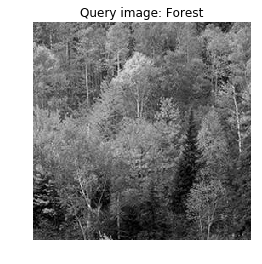

Query: data\scene\test\Forest\image_0306.jpg
Top 1 match: data\scene\train\Forest\image_0144.jpg, distance: 1.2866
Top 2 match: data\scene\train\Forest\image_0140.jpg, distance: 1.2933
Top 3 match: data\scene\train\Forest\image_0097.jpg, distance: 1.2949
Top 4 match: data\scene\train\Forest\image_0054.jpg, distance: 1.2987
Top 5 match: data\scene\train\Forest\image_0100.jpg, distance: 1.2997


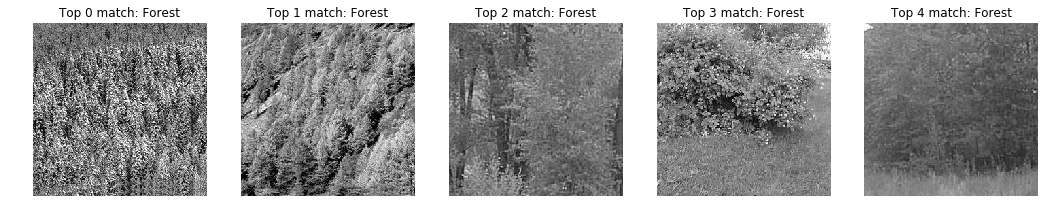

In [7]:
# test and evaluation
dist_list = []
display_random_numer = random.randint(0,len(ret_file_path_list_vlad)-1)
for eachpic in range(len(vlad_base)):
    dist = cal_vec_dist(ret_vlad_list[display_random_numer], vlad_base[eachpic])
    dist_list.append(dist)
    
# Find the top top_return similar results
dist_array = np.array(dist_list)
top_return = 5
index = np.argsort(dist_array)[:top_return]

plt.imshow(cv2.cvtColor(cv2.imread(ret_file_path_list_vlad[display_random_numer]), cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Query image: ' + ret_file_path_list_vlad[display_random_numer].split("\\")[3])
plt.show()

print("Query: %s" % (ret_file_path_list_vlad[display_random_numer]))

# Display results
plt.figure(figsize=(18,8))
for i in range(top_return):
    plt.subplot(1,top_return,i+1)
    plt.imshow(cv2.cvtColor(cv2.imread(train_image_file_list[index[i]]), cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title('Top ' + str(i) + ' match: ' + train_image_file_list[index[i]].split("\\")[3])
    print("Top %d match: %s, distance: %.4f" % (i+1, train_image_file_list[index[i]], dist_array[index[i]]))
plt.show()

## Neural Codes: Step 0, Define functions

- Reference: Artem Babenko, Anton Slesarev, Alexandr Chigorin, Victor Lempitsky, "Neural Codes for Image Retrieval," ECCV 2014, https://arxiv.org/abs/1404.1777

- Process
    - Extract `fc2` layer coefficients as the features
    - Apply cosine similarity (dot product) as the similarity score


In [8]:
# Define VGG baseline model
vgg_model = vgg16.VGG16(weights='imagenet', include_top=True)
vgg_model.summary()

# Define VGG extracting fc2 layer coefficients
vgg_model_extract_fc2 = Model(inputs=vgg_model.input, outputs=vgg_model.get_layer('fc2').output)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [9]:
# A VGG model file (553 MB) will be downloaded from the Internet for the first time of running this code

def extract_vgg_fc_feature_from_list(image_file_list):
    all_feature = []
    for idx, eachFile in enumerate(image_file_list):
        if ((idx % 100) ==0 ):
            print("process %d/%d file" % (idx+1, len(image_file_list)))
        img = image.load_img(eachFile, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        fc2_features = vgg_model_extract_fc2.predict(x)
        fc2_features = fc2_features/np.linalg.norm(fc2_features) # normalzie features
        all_feature.append(fc2_features)
    return all_feature


## Neural Codes: Step 1, Feature extraction from from both training and test data set

In [10]:
# Extract features from training images
train_all_feature_vgg_fc = extract_vgg_fc_feature_from_list(train_image_file_list)
print("Dimension of Train_all_feature_vgg_fc: (%d, %d)" % (len(train_all_feature_vgg_fc), train_all_feature_vgg_fc[0].shape[1]))
np.save('data\\train_all_feature_vgg_fc.npy', train_all_feature_vgg_fc)

# Extract features from test images
# get all the descriptor vectors of the whole test data set
number_test_images = len(test_image_file_list) 
ret_file_path_list = random.sample(test_image_file_list, number_test_images)

print('Extract features from test images')
test_all_feature_vgg_fc = extract_vgg_fc_feature_from_list(ret_file_path_list)
print("Test_all_feature_vgg_fc: (%d, %d)" % (len(test_all_feature_vgg_fc), test_all_feature_vgg_fc[0].shape[1]))
np.save('data\\test_all_feature_vgg_fc.npy', test_all_feature_vgg_fc)
np.save('data\\ret_file_path_list_vgg_fc.npy', ret_file_path_list)

# It takes some time to extract features, so we can directly load the pre-extracted features.
train_all_feature_vgg_fc = np.load('data\\train_all_feature_vgg_fc.npy')
test_all_feature_vgg_fc = np.load('data\\test_all_feature_vgg_fc.npy')
ret_file_path_list_vgg_fc = np.load('data\\ret_file_path_list_vgg_fc.npy')
print("Dimension of Train_all_feature_vgg_fc: (%d, %d)" % (len(train_all_feature_vgg_fc), train_all_feature_vgg_fc[0].shape[1]))
print("Test_all_feature_vgg_fc: (%d, %d)" % (len(test_all_feature_vgg_fc), test_all_feature_vgg_fc[0].shape[1]))

process 1/1500 file
process 101/1500 file
process 201/1500 file
process 301/1500 file
process 401/1500 file
process 501/1500 file
process 601/1500 file
process 701/1500 file
process 801/1500 file
process 901/1500 file
process 1001/1500 file
process 1101/1500 file
process 1201/1500 file
process 1301/1500 file
process 1401/1500 file
Dimension of Train_all_feature_vgg_fc: (1500, 4096)
Extract features from test images
process 1/2985 file
process 101/2985 file
process 201/2985 file
process 301/2985 file
process 401/2985 file
process 501/2985 file
process 601/2985 file
process 701/2985 file
process 801/2985 file
process 901/2985 file
process 1001/2985 file
process 1101/2985 file
process 1201/2985 file
process 1301/2985 file
process 1401/2985 file
process 1501/2985 file
process 1601/2985 file
process 1701/2985 file
process 1801/2985 file
process 1901/2985 file
process 2001/2985 file
process 2101/2985 file
process 2201/2985 file
process 2301/2985 file
process 2401/2985 file
process 2501/2985 

## Neural Codes: Step 2, Performance evaluation

In [11]:
##test and evaluation
avg_precision = []
avg_accuracy = []
top_return = 5
for i in range(len(test_all_feature_vgg_fc)):
    dist_list = []
    if ((i % 200) ==0 ):
        print("process %d/%d file" % (i+1, len(test_all_feature_vgg_fc)))
    for eachpic in range(len(train_all_feature_vgg_fc)):
        dist = cal_vec_dist(test_all_feature_vgg_fc[i], train_all_feature_vgg_fc[eachpic])
        dist_list.append(dist)

    most_sim = np.array(dist_list)

    #choose the three nearest images of the given image 
    index = np.argsort(most_sim)[:top_return]
    input_file_name = ret_file_path_list_vgg_fc[i]
    result_file_name_list = []
    for j in range(len(index)):
        result_file_name_list.append(train_image_file_list[index[j]])
    avg_precision.append(cal_precision(input_file_name, result_file_name_list))
    avg_accuracy.append(cal_accuracy(input_file_name, result_file_name_list))
    
print("Top %d return, mean Precision: %.4f" % (top_return, np.array(avg_precision).mean()))
print("Top %d return, mean Accuracy: %.4f" % (top_return, np.array(avg_accuracy).mean()))


process 1/2985 file
process 201/2985 file
process 401/2985 file
process 601/2985 file
process 801/2985 file
process 1001/2985 file
process 1201/2985 file
process 1401/2985 file
process 1601/2985 file
process 1801/2985 file
process 2001/2985 file
process 2201/2985 file
process 2401/2985 file
process 2601/2985 file
process 2801/2985 file
Top 5 return, mean Precision: 0.7784
Top 5 return, mean Accuracy: 0.9631


## Neural Codes: Step 3, Visualize the query results

- Randomly choose a query image (see `display_random_numer`) and perform instance search

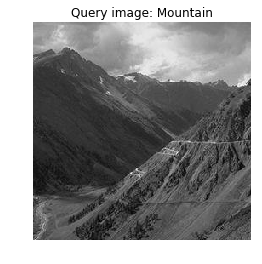

Query: data\scene\test\Mountain\image_0193.jpg
Top 1 match: data\scene\train\Mountain\image_0054.jpg, distance: 0.5598
Top 2 match: data\scene\train\Mountain\image_0185.jpg, distance: 0.6118
Top 3 match: data\scene\train\Mountain\image_0302.jpg, distance: 0.6161
Top 4 match: data\scene\train\Mountain\image_0352.jpg, distance: 0.6186
Top 5 match: data\scene\train\OpenCountry\image_0332.jpg, distance: 0.6206


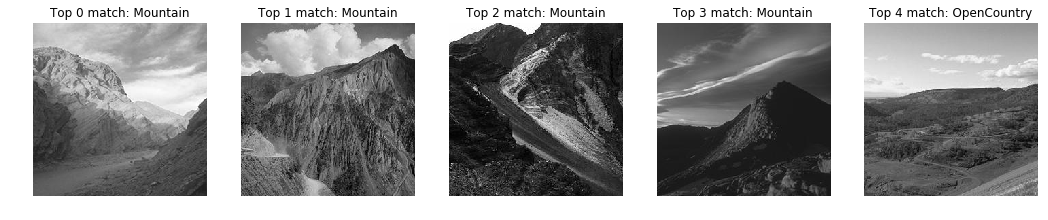

In [12]:
# test and evaluation
dist_list = []
display_random_numer = random.randint(0, len(ret_file_path_list_vgg_fc)-1)
for eachpic in range(len(train_all_feature_vgg_fc)):
    dist = cal_vec_dist(test_all_feature_vgg_fc[display_random_numer], train_all_feature_vgg_fc[eachpic])
    dist_list.append(dist)
    
# Find the top top_return similar results
dist_array = np.array(dist_list)
top_return = 5
index = np.argsort(dist_array)[:top_return]

plt.imshow(cv2.cvtColor(cv2.imread(ret_file_path_list_vgg_fc[display_random_numer]), cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Query image: ' + ret_file_path_list_vgg_fc[display_random_numer].split("\\")[3])
plt.show()

print("Query: %s" % (ret_file_path_list_vgg_fc[display_random_numer]))

# Display results
plt.figure(figsize=(18,8))
for i in range(top_return):
    plt.subplot(1,top_return,i+1)
    plt.imshow(cv2.cvtColor(cv2.imread(train_image_file_list[index[i]]), cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title('Top ' + str(i) + ' match: ' + train_image_file_list[index[i]].split("\\")[3])
    print("Top %d match: %s, distance: %.4f" % (i+1, train_image_file_list[index[i]], dist_array[index[i]]))
plt.show()

## Global pooling: Step 0, Define functions

- Reference:

    - `Global sum-pooling`, Artem Babenko, Victor Lempitsky, "Aggregating Deep Convolutional Features for Image Retrieval," ICCV 2015, https://arxiv.org/abs/1510.07493

    - `Global max-pooling`, Giorgos Tolias, Ronan Sicre, Hervé Jégou, "Particular object retrieval with integral max-pooling of CNN activations," ICLR 2016, https://arxiv.org/abs/1511.05879

    
- Process
    - Extract `block5_conv3` layer coefficients, then apply either global sum-pooling or max-pooling to generate features.
    - Apply cosine similarity (dot product) as the similarity score
    

In [13]:
# Define VGG extracting block5_conv3 layer coefficients
vgg_model_extract_blk5conv3 = Model(inputs=vgg_model.input, outputs=vgg_model.get_layer('block5_conv3').output)


In [14]:

def extract_vgg_conv_feature_from_list(image_file_list, mode='sum'):
    all_feature = []
    for idx, eachFile in enumerate(image_file_list):
        if ((idx % 100) ==0 ):
            print("process %d/%d file" % (idx+1, len(image_file_list)))
            
        img = image.load_img(eachFile, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        conv_features = vgg_model_extract_blk5conv3.predict(x)
        if (mode == 'sum'):
            conv_features = np.sum(conv_features, axis=(1,2))
            conv_features = conv_features/np.linalg.norm(conv_features) # normalzie features
        elif (mode == 'max'):
            conv_features = np.sum(conv_features, axis=(1,2))
            conv_features = conv_features/np.linalg.norm(conv_features) # normalzie features
        else:
            print('extract_vgg_conv_feature_from_list: Wrong mode as input')
            break
        all_feature.append(conv_features)
    return all_feature


## Global pooling: Step 1, Feature extraction from from both training and test data set

In [15]:
# # Extract features from training images
train_all_feature_vgg_conv = extract_vgg_conv_feature_from_list(train_image_file_list, 'sum')
np.save('data\\train_all_feature_vgg_conv.npy', train_all_feature_vgg_conv)
print("Train_all_feature_vgg_conv: (%d, %d)" % (len(train_all_feature_vgg_conv), train_all_feature_vgg_conv[0].shape[1]))

# # Extract features from test images
# # get all the descriptor vectors of the whole test data set
number_test_images = len(test_image_file_list)
ret_file_path_list = random.sample(test_image_file_list, number_test_images)

print('Extract features from test images')
test_all_feature_vgg_conv = extract_vgg_conv_feature_from_list(ret_file_path_list)
print("Test_all_feature_vgg_conv: (%d, %d)" % (len(test_all_feature_vgg_conv), test_all_feature_vgg_conv[0].shape[1]))
np.save('data\\test_all_feature_vgg_conv.npy', test_all_feature_vgg_conv)
np.save('data\\ret_file_path_list_vgg_conv.npy', ret_file_path_list)

train_all_feature_vgg_conv = np.load('data\\train_all_feature_vgg_conv.npy')
test_all_feature_vgg_conv = np.load('data\\test_all_feature_vgg_conv.npy')
ret_file_path_list_vgg_conv = np.load('data\\ret_file_path_list_vgg_conv.npy')
print("Train_all_feature_vgg_conv: (%d, %d)" % (len(train_all_feature_vgg_conv), train_all_feature_vgg_conv[0].shape[1]))
print("Test_all_feature_vgg_conv: (%d, %d)" % (len(test_all_feature_vgg_conv), test_all_feature_vgg_conv[0].shape[1]))


process 1/1500 file
process 101/1500 file
process 201/1500 file
process 301/1500 file
process 401/1500 file
process 501/1500 file
process 601/1500 file
process 701/1500 file
process 801/1500 file
process 901/1500 file
process 1001/1500 file
process 1101/1500 file
process 1201/1500 file
process 1301/1500 file
process 1401/1500 file
Train_all_feature_vgg_conv: (1500, 512)
Extract features from test images
process 1/2985 file
process 101/2985 file
process 201/2985 file
process 301/2985 file
process 401/2985 file
process 501/2985 file
process 601/2985 file
process 701/2985 file
process 801/2985 file
process 901/2985 file
process 1001/2985 file
process 1101/2985 file
process 1201/2985 file
process 1301/2985 file
process 1401/2985 file
process 1501/2985 file
process 1601/2985 file
process 1701/2985 file
process 1801/2985 file
process 1901/2985 file
process 2001/2985 file
process 2101/2985 file
process 2201/2985 file
process 2301/2985 file
process 2401/2985 file
process 2501/2985 file
process

## Global pooling: Step 2, Performance evaluation

In [16]:
##test and evaluation
avg_precision = []
avg_accuracy = []
top_return = 5
for i in range(len(test_all_feature_vgg_conv)):
    dist_list = []
    if ((i % 200) ==0 ):
        print("process %d/%d file" % (i+1, len(test_all_feature_vgg_conv)))
    for eachpic in range(len(train_all_feature_vgg_conv)):
        dist = cal_vec_dist(test_all_feature_vgg_conv[i], train_all_feature_vgg_conv[eachpic])
        dist_list.append(dist)

    most_sim = np.array(dist_list)

    #choose the three nearest images of the given image 
    index = np.argsort(most_sim)[:top_return]
    input_file_name = ret_file_path_list_vgg_conv[i]
    result_file_name_list = []
    for j in range(len(index)):
        result_file_name_list.append(train_image_file_list[index[j]])
    avg_precision.append(cal_precision(input_file_name, result_file_name_list))
    avg_accuracy.append(cal_accuracy(input_file_name, result_file_name_list))
    
print("Top %d return, mean Precision: %.4f" % (top_return, np.array(avg_precision).mean()))
print("Top %d return, mean Accuracy: %.4f" % (top_return, np.array(avg_accuracy).mean()))


process 1/2985 file
process 201/2985 file
process 401/2985 file
process 601/2985 file
process 801/2985 file
process 1001/2985 file
process 1201/2985 file
process 1401/2985 file
process 1601/2985 file
process 1801/2985 file
process 2001/2985 file
process 2201/2985 file
process 2401/2985 file
process 2601/2985 file
process 2801/2985 file
Top 5 return, mean Precision: 0.7791
Top 5 return, mean Accuracy: 0.9638


## Global pooling: Step 3, Visualize the query results

$\color{red}{\text{Q1. Complete code to perform instance search using global pooling method}}$

Tasks

- Randomly choose a query image (see `display_random_numer`)
- Calculate the distance between the test data `test_all_feature_vgg_conv[display_random_numer]` and all train data feature `train_all_feature_vgg_conv`
- Sort the distance matrix and pick up the top return `top_return`
- Visualize the input image, the top return images and their similarity score.

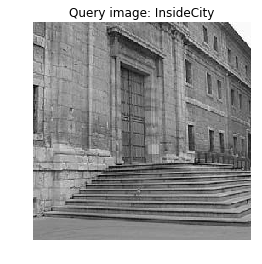

Query: data\scene\test\InsideCity\image_0043.jpg
Top 1 match: data\scene\train\InsideCity\image_0030.jpg, distance: 0.7327
Top 2 match: data\scene\train\Street\image_0183.jpg, distance: 0.7510
Top 3 match: data\scene\train\TallBuilding\image_0130.jpg, distance: 0.7640
Top 4 match: data\scene\train\Street\image_0229.jpg, distance: 0.7646
Top 5 match: data\scene\train\Street\image_0011.jpg, distance: 0.7770


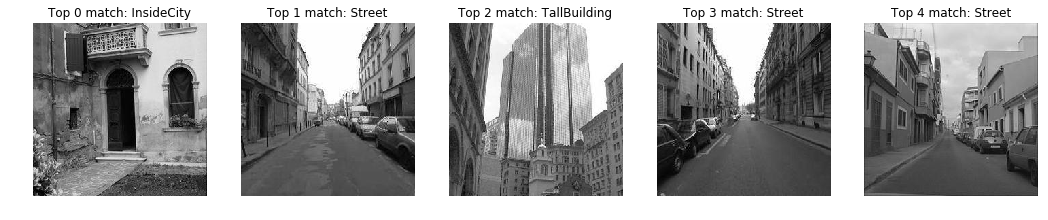

In [19]:
# test and evaluation
dist_list = []
display_random_numer = random.randint(0, len(ret_file_path_list_vgg_conv)-1)
for eachpic in range(len(train_all_feature_vgg_conv)):
    dist = cal_vec_dist(test_all_feature_vgg_conv[display_random_numer], train_all_feature_vgg_conv[eachpic])
    dist_list.append(dist)
    
# Find the top top_return similar results
dist_array = np.array(dist_list)
top_return = 5
index = np.argsort(dist_array)[:top_return]

plt.imshow(cv2.cvtColor(cv2.imread(ret_file_path_list_vgg_conv[display_random_numer]), cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Query image: ' + ret_file_path_list_vgg_conv[display_random_numer].split("\\")[3])
plt.show()

print("Query: %s" % (ret_file_path_list_vgg_conv[display_random_numer]))

# Display results
plt.figure(figsize=(18,8))
for i in range(top_return):
    plt.subplot(1,top_return,i+1)
    plt.imshow(cv2.cvtColor(cv2.imread(train_image_file_list[index[i]]), cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title('Top ' + str(i) + ' match: ' + train_image_file_list[index[i]].split("\\")[3])
    print("Top %d match: %s, distance: %.4f" % (i+1, train_image_file_list[index[i]], dist_array[index[i]]))
plt.show()

$\color{red}{\text{Q2. List methods that are potential to boost the performance of this approach, such as apply PCA on feature dimension reduction.}}$

In [19]:
# Provide your answers here
# 1. create an ensemble model that comprises of multiple models e.g. using different output layer, using different pooling mode or on different dimension, then take the best performer or their average.
#
# 2. apply VGG to the input image to produce a 28x28x512 output, then apply max activation to reduce it to 28x28x1, then apply GIST to produce the final feature vector.
#
# 

**Once you finish the workshop, rename your .ipynb file to your name, and submit your .ipynb file into LumiNUS.**

Have a nice day!